In [13]:
from src import PINNViga
from src import Carga
from src import Apoio
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import time
import torch
import torch.nn as nn

VIGA BIAPOIADA

In [14]:
## SEÇÃO DA VIGA

b = 0.2
h = 0.4
E = 30e9
I = b * (h ** 3) / 12
EI = E * I

In [15]:
# VIGA BIAPOIADA
# CRIANDO OS APOIOS

L = 4

## CRIANDO OS APOIOS

apoio_esq = Apoio.Apoio([1, 1, 0], [0, 0])
apoio_meio = Apoio.Apoio([1, 1, 0], [L / 2, 0])
apoio_dir = Apoio.Apoio([0, 1, 0], [L, 0])

lista_apoios = [apoio_esq, apoio_meio, apoio_dir]

## CRIANDO CARGAS

q = -10e3

q2 = Carga.CargaDistribuida([0, q], [0, 0], [L, 0])

cargas = [q2]

In [16]:
## LOOP DE TREINAMENTO

biapoiada = PINNViga.PINNViga(lista_apoios, cargas, E, I)
biapoiada.run_model(num_epochs=5000, pde_weight=1, bc_weight=1, int_weight = 1, tol = 1e-10, tol_apoio=1e-10)

Epoch 0, Loss: 3.731256484985, PDE Loss: 3.409111261368, BC Loss: 0.181518167257, INT Loss: 0.140627250075
Epoch 500, Loss: 0.007908137515, PDE Loss: 0.002189009916, BC Loss: 0.004473843612, INT Loss: 0.001245283638
Epoch 1000, Loss: 0.000425425824, PDE Loss: 0.000363657658, BC Loss: 0.000048713897, INT Loss: 0.000013054262
Epoch 1500, Loss: 0.000172195825, PDE Loss: 0.000163392921, BC Loss: 0.000006908167, INT Loss: 0.000001894735
Epoch 2000, Loss: 0.000084128173, PDE Loss: 0.000081774328, BC Loss: 0.000001843258, INT Loss: 0.000000510587
Epoch 2500, Loss: 0.000043495234, PDE Loss: 0.000042783373, BC Loss: 0.000000560210, INT Loss: 0.000000151652
Epoch 3000, Loss: 0.000159080315, PDE Loss: 0.000153753906, BC Loss: 0.000004309339, INT Loss: 0.000001017065
Epoch 3500, Loss: 0.000415188784, PDE Loss: 0.000406994135, BC Loss: 0.000005731693, INT Loss: 0.000002462964
Epoch 4000, Loss: 0.000007722639, PDE Loss: 0.000007702344, BC Loss: 0.000000016629, INT Loss: 0.000000003665
Epoch 4500, Lo

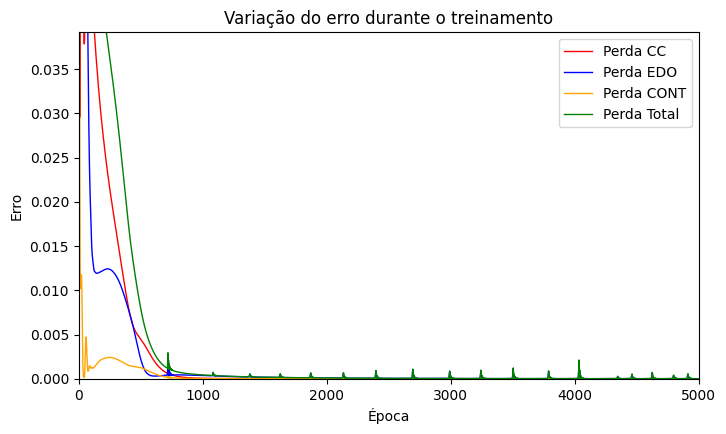

In [17]:
biapoiada.plot_errors(100)

In [18]:

from anastruct import SystemElements

ss = SystemElements(EI=EI, EA=1e12)  # EA grande para desprezar esforços axiais
tam = 40
for k in range(tam):
    ss.add_element([[(k)*L/tam,0], [(k+1)*L/tam,0]])   # trecho 1
    ss.q_load(q=q, element_id=ss.id_last_element, direction='element')

ss.add_support_hinged(node_id=1)    # apoio esquerdo = [1,1,0]
ss.add_support_roll(node_id=int(tam/2)+1)   # apoio no meio  = [1,1,0]
ss.add_support_roll(node_id=tam+1)   # apoio direito  = [0,1,0]  (equivalente a rolete Y fixado, X livre)  # N/m

ss.solve()

array([ 0.00000000e+00,  0.00000000e+00, -5.20833333e-05, -2.41867746e-25,
        5.17057299e-06, -5.09635416e-05, -4.77612259e-25,  1.01250001e-05,
       -4.78124998e-05, -7.07233554e-25,  1.46757817e-05, -4.29427076e-05,
       -9.30731580e-25,  1.86666669e-05, -3.66666662e-05, -1.14810637e-24,
        2.19726562e-05, -2.92968750e-05, -1.35935800e-24,  2.45000005e-05,
       -2.11458313e-05, -1.56448626e-24,  2.61861977e-05, -1.25260427e-05,
       -1.76349141e-24,  2.70000000e-05, -3.74999896e-06, -1.95637322e-24,
        2.69414063e-05,  4.86978964e-06, -2.14313190e-24,  2.60416667e-05,
        1.30208333e-05, -2.32376734e-24,  2.43632807e-05,  2.03906266e-05,
       -2.49827955e-24,  2.19999987e-05,  2.66666693e-05, -2.66666833e-24,
        1.90768244e-05,  3.15364564e-05, -2.82893407e-24,  1.57500008e-05,
        3.46874995e-05, -2.98507657e-24,  1.22070312e-05,  3.58072916e-05,
       -3.13509584e-24,  8.66666584e-06,  3.45833327e-05, -3.27899187e-24,
        5.37890478e-06,  

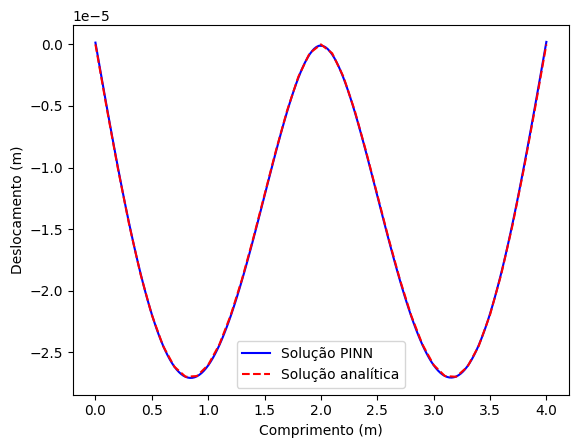

In [19]:
dy = [ss.get_node_displacements()[id]['uy'] for id in range(tam +1)]

x_plot = torch.linspace(0, 1, 101).view(-1,1)
u_plot_star = biapoiada.model(x_plot).detach().numpy()
biapoiada.u_plot = u_plot_star
biapoiada.x_plot = (x_plot.numpy() * L)

u_pred = biapoiada.model(x_plot).detach().numpy()

for k, trecho in enumerate(biapoiada.trechos_cargas):
    x0 = trecho['x0']
    x1 = trecho['x1']
    u_trecho = u_pred[:, k : k+1] * trecho['u_ref'] * (-1)
    x_trecho = np.linspace(x0, x1, len(u_trecho))
    if k == 0:
        plt.plot(x_trecho, u_trecho, color = 'blue', label = "Solução PINN")

    else:
        plt.plot(x_trecho, u_trecho, color = 'blue')
    plt.xlabel("Comprimento (m)")
    plt.ylabel("Deslocamento (m)")

plt.plot(np.linspace(0, 4, 41), dy, color = 'red', label = "Solução analítica", ls= '--')
plt.legend()